# Customer Attrition Model - Part 5
## Prediction Model Verification

# 5.0 Notebook Brief

In Notebook 4.0, we have completed a churn prediction model with F1 score of 0.69 and AUC of 0.73.
With prediction using past data, we are yet to be able to verify if such a model is capable of predict upcoming churn probable users. Hence, in this notebook we will use Survival Analysis and compare the predictions against our model's false positive predictions.

## 5.1 Data Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#survival analysis lib
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import restricted_mean_survival_time, median_survival_times


In [3]:
#import clustered dataset with cust ID
telco = pd.read_csv('../data/telco_clustered_ID.csv')

#for verification
false_po = pd.read_csv('../data/telco_false_po.csv')
false_neg = pd.read_csv('../data/telco_false_neg.csv')

pd.set_option('display.max_columns',99)

In [4]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user,cluster,customer_id
0,0,78,0,1,0,0,0,Los Angeles,1,0,0,DSL,0,0,1,0,0,1,Month-to-month,1,Electronic check,1,100,5433,Competitor offered more data,0,0,None,0.00,DSL,8,0,0,39.65,39.65,0.00,20,0.00,59.65,3,1,Competitor,15334,0,price_sensitive,8779-QRDMV
1,1,74,0,1,1,1,1,Los Angeles,8,1,1,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Credit card (automatic),1,69,5302,Competitor made better offer,1,1,Offer E,48.85,Fiber Optic,17,0,1,80.65,633.30,0.00,0,390.80,1024.10,3,1,Competitor,17038,0,price_sensitive,7495-OOKFY
2,0,71,0,1,0,1,3,Los Angeles,18,1,1,Fiber optic,0,0,0,0,1,1,Month-to-month,1,Electronic check,1,81,3179,Competitor made better offer,0,0,Offer D,11.33,Fiber Optic,52,1,1,95.45,1752.55,45.61,0,203.94,1910.88,2,1,Competitor,8625,0,price_sensitive,1658-BYGOY
3,1,78,0,1,1,1,1,Inglewood,25,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,1,88,5337,Limited range of services,1,1,Offer C,19.76,Fiber Optic,12,0,1,98.50,2514.50,13.43,0,494.00,2995.07,2,1,Dissatisfaction,11799,0,price_sensitive,4598-XLKNJ
4,1,80,0,1,1,1,1,Whittier,37,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,1,67,2793,Extra data charges,1,1,Offer C,6.33,Fiber Optic,14,0,1,76.50,2868.15,0.00,0,234.21,3102.36,2,1,Price,6947,0,price_sensitive,4846-WHAFZ


## 5.2 Survival Analysis

Survival analysis is a statistical branch where it analyse the expected duration of time until one even occurs, commonly death, in this context is customer churn. Survival analysis models time until the event. We only have data up till date and during the time of this study, we have yet to know the probability of which customer would churn in the near future, known as censored observation [(STHDA, n.d.)](http://www.sthda.com/english/wiki/survival-analysis-basics).

Censoring may arise in the following ways:
1. a user has not (yet) experienced the event of interest, such as relapse or death, within the study time period;
2. a user experiences a different event that makes further follow-up impossible, i.e. death.

This type of censoring, named right censoring, is handled in survival analysis.

### 5.2.1 Kaplan Meier Curves in General

Kaplan Meier Estimator is a non parametric statistic to estimate the survival function from the lifetime data. Below is the Kaplan Meier method to estimate the survival function.

\begin{align*}
\hat S_{t} = \prod_{t_{t}\leq t}[1 - \frac{d_{i}}{n_{i}}]
\end{align*}

where $t$ is a time period known as the survival time, time to failure or time to event (such as death)

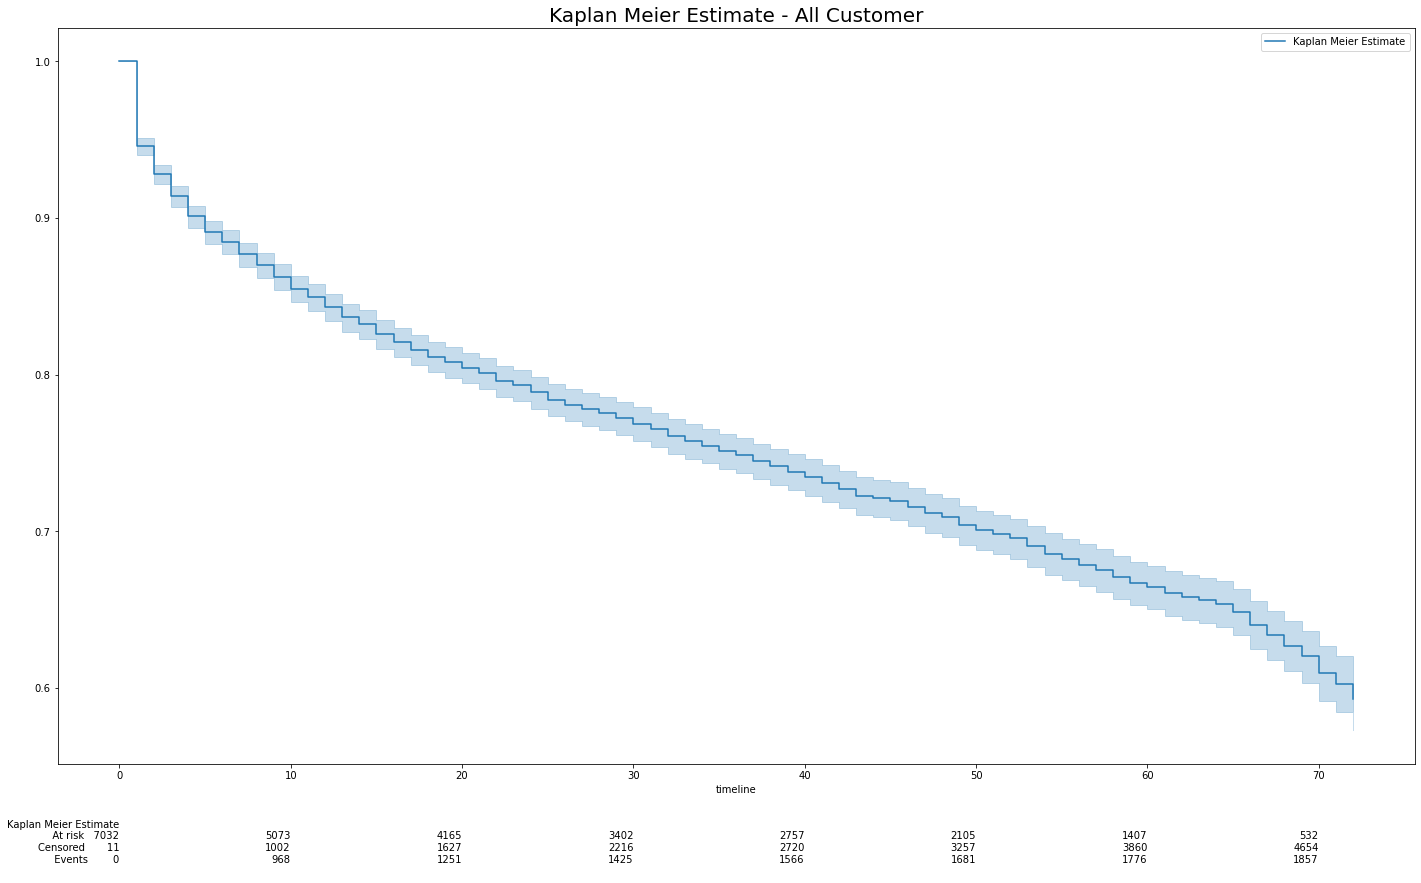

In [10]:
duration = telco['tenure_months'] 
event_observed = telco['customer_status']  

# instantiate km
km = KaplanMeierFitter() 

#plot figure
plt.figure(figsize=(20,12))
# Fit
km.fit(duration, event_observed,label='Kaplan Meier Estimate')

# Create an estimate
km.plot_survival_function(at_risk_counts=True)

plt.title('Kaplan Meier Estimate - All Customer',fontsize=20)
plt.ylabel("Probability")
plt.savefig('../images/surv_kmf_all.png')
plt.show()

*Interpretation: The kaplan meier curves provides us information on the survivability of the users, which were not able to be verify using previous modellings or EDA. Based on the above, over 7043 users, the retention probability is over 60% at the end of 72 months.*

*At risk indicates the 532 number of customers with an observed tenure of more than 70 months.*

*While censored is number of customers with a tenure equal to or less than the point in time, which were not churned. For example, 3,860 customers had a tenure of 60 months or less however, they had not churned then.* 

*Events in this case signifies number of customers with a tenure equal to or less than the point in time, which had churned by then. For instance, 1,681 customers had a tenure of 50 months or less and had churned by then.*

### 5.2.2 Kaplan Meier Curves by Cohorts

To cross reference to our observation based on the k-means clustered groups, we will also review the survival curves based on the clusters. 

In [6]:
#proportion of clusters
telco.cluster.value_counts(normalize=True)

price_sensitive    0.294051
heavyweight        0.270339
minimalist         0.218515
vanilla            0.217095
Name: cluster, dtype: float64

In [7]:
def plot_categorical_KM_Curve(feature, t='tenure_months', event='customer_status', df=telco, ax=None):
    '''function to plot kmcurve'''
    #instantiater
    kmf = KaplanMeierFitter() 
    
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        rmst = restricted_mean_survival_time(kmf, t=time_limit)
        print(f'Restricted Mean Survival Time ({cat}): {rmst:.2f} months')
        kmf.plot(ax=ax, label=cat,)

Restricted Mean Survival Time (price_sensitive): 23.13 months
Restricted Mean Survival Time (vanilla): 40.22 months
Restricted Mean Survival Time (heavyweight): 49.67 months
Restricted Mean Survival Time (minimalist): 46.45 months


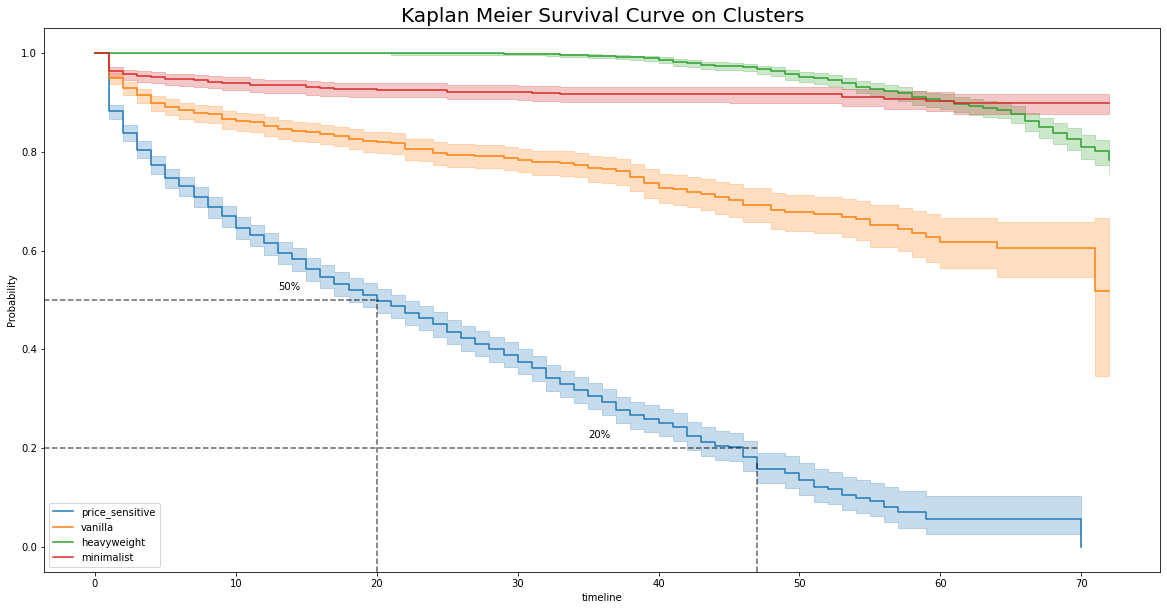

In [50]:
plt.subplots(nrows = 1, ncols = 1, figsize=(20,10),)

#setting time limit 
time_limit = 50

#plot km curve by cluster
plot_categorical_KM_Curve(feature='cluster',t='tenure_months', event='customer_status', df=telco, ax=None,)

plt.axhline(y=0.5, xmax=0.3,c='k', alpha=0.6, linestyle='--')
plt.axvline(x=20, ymax=0.5, c='k', alpha=0.6, linestyle='--')
plt.text(13, 0.52, '50%')
plt.axhline(y=0.2, xmax=0.64,c='k', alpha=0.6, linestyle='--')
plt.axvline(x=47, ymax=0.2, c='k', alpha=0.6, linestyle='--')
plt.text(35, 0.22, '20%')
plt.title('Kaplan Meier Survival Curve on Clusters',fontsize=20)
plt.legend(loc='lower left')
plt.ylabel("Probability")
plt.savefig('../images/surv_kmf_cohort.png')
plt.show()

*Interpretation: As in our clustering EDA estimation, the survival time expected from **price-sensitive** customers are the shortest with only 23 months(2 years contract) and highest for **heavyweight** users with 49 months, almost twice the tenure.*

### 5.2.3 Covariate Analysis

For the covariates study, we will review the following columns on the business subscription offers and its direct effect in customer churn rate.

In [11]:
#covariate columns
kmf_col = ['internet_service','offer','contract','payment_method']

Restricted Mean Survival Time (DSL): 42.16 months
Restricted Mean Survival Time (Fiber optic): 35.81 months
Restricted Mean Survival Time (No): 46.52 months
Restricted Mean Survival Time (None): 39.78 months
Restricted Mean Survival Time (Offer E): 14.15 months
Restricted Mean Survival Time (Offer D): 32.27 months
Restricted Mean Survival Time (Offer C): 40.60 months
Restricted Mean Survival Time (Offer B): 49.66 months
Restricted Mean Survival Time (Offer A): 50.00 months
Restricted Mean Survival Time (Month-to-month): 30.09 months
Restricted Mean Survival Time (One year): 48.57 months
Restricted Mean Survival Time (Two year): 49.95 months
Restricted Mean Survival Time (Electronic check): 32.30 months
Restricted Mean Survival Time (Credit card (automatic)): 45.76 months
Restricted Mean Survival Time (Mailed check): 40.28 months
Restricted Mean Survival Time (Bank transfer (automatic)): 45.30 months


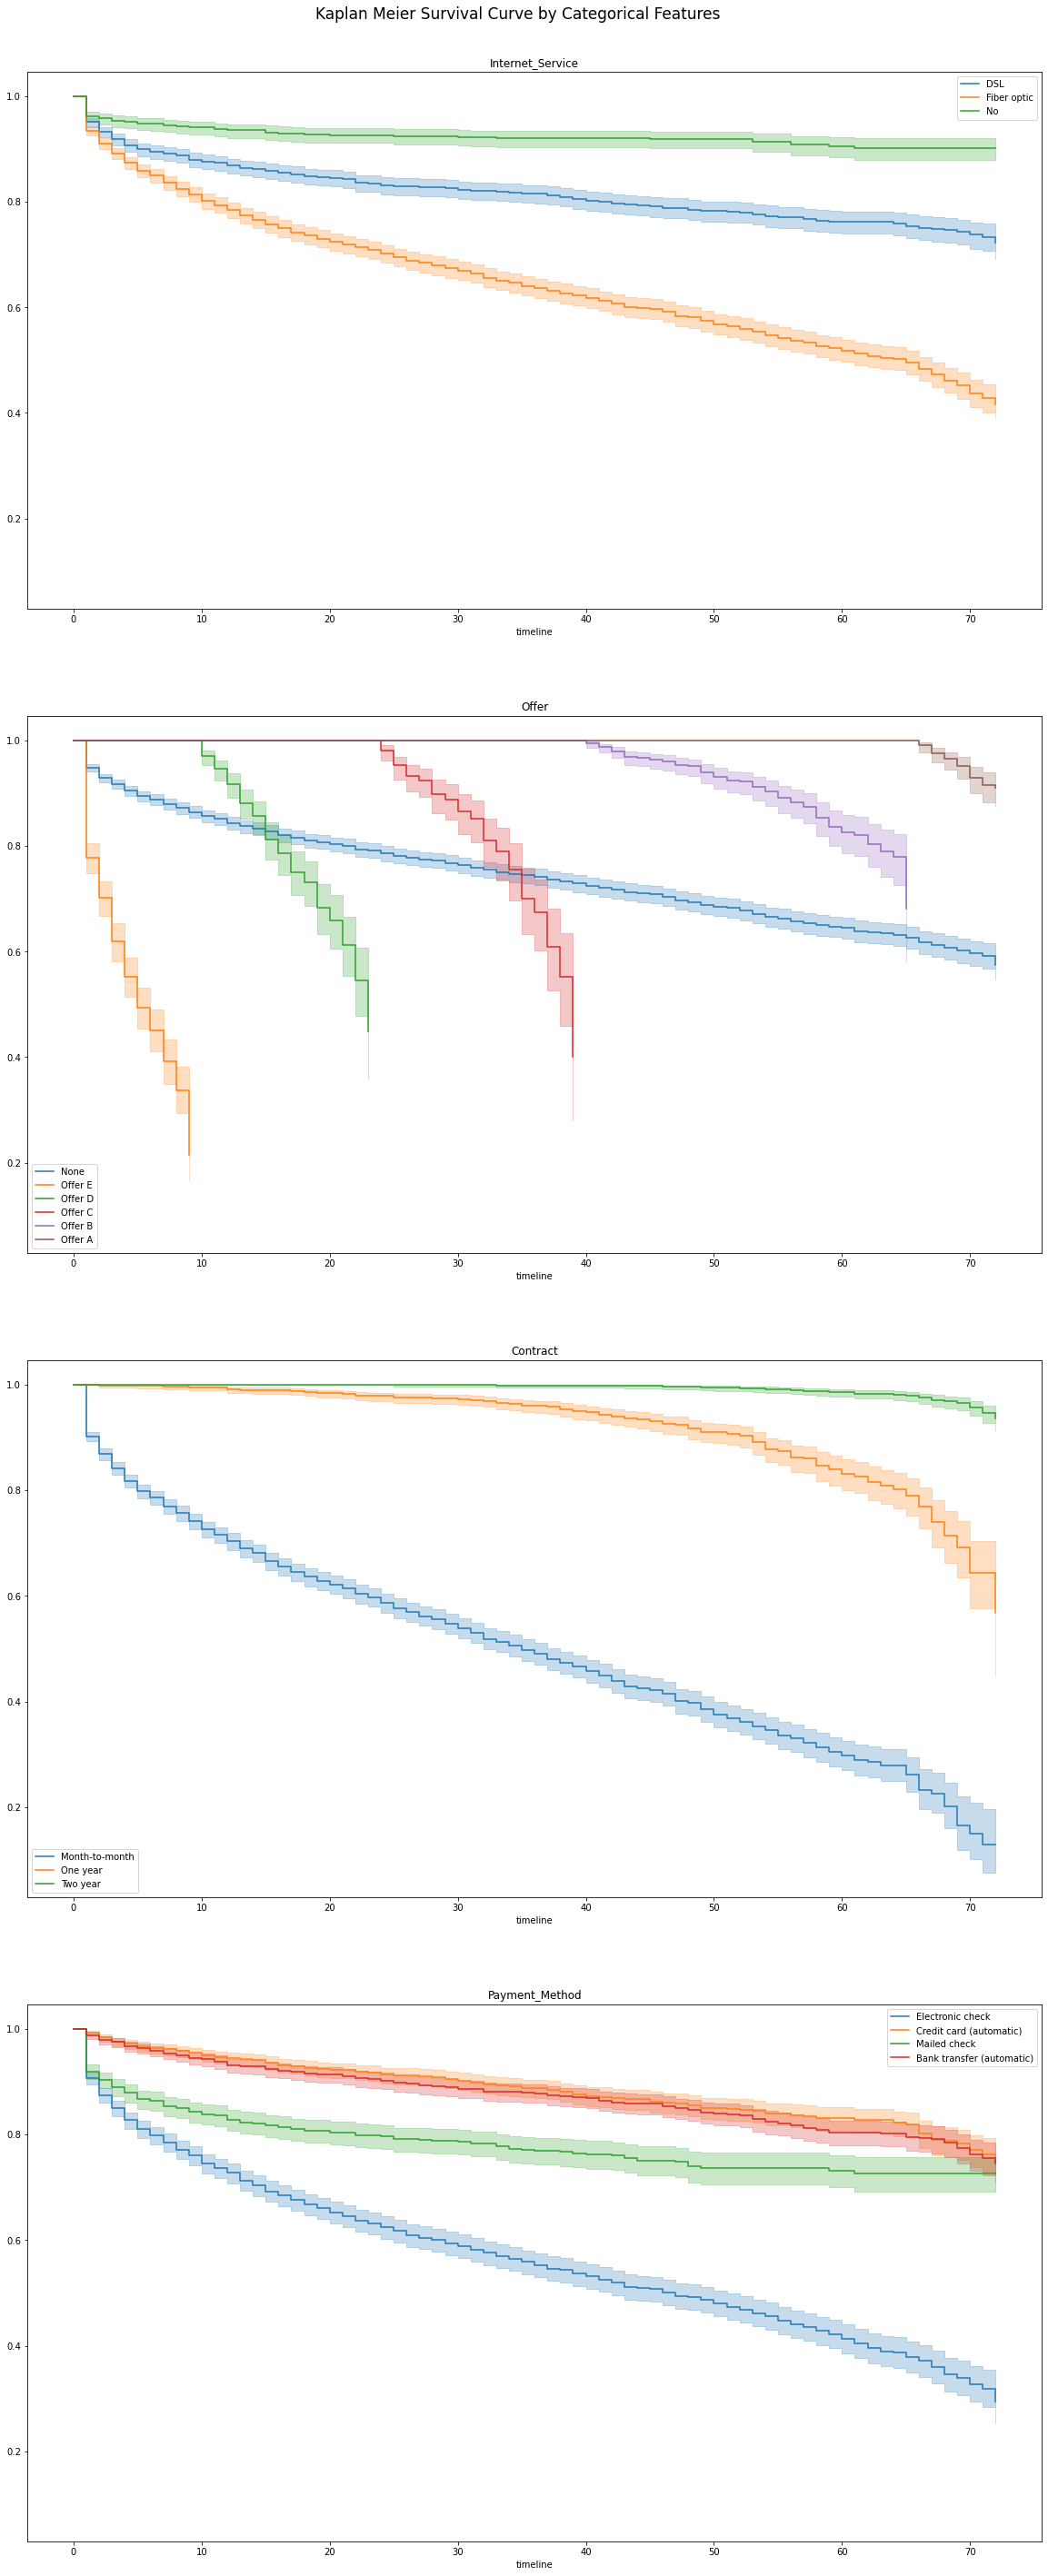

In [12]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(20,50), sharex=False, sharey=True)
ax = ax.flatten()

for idx, col in enumerate(kmf_col):
    #instantiater
    kmf = KaplanMeierFitter() 
    #plot km curve by cluster
    plot_categorical_KM_Curve(feature=col,t='tenure_months', event='customer_status', df=telco, ax=ax[idx])
    ax[idx].set_title(col.title())

plt.suptitle('Kaplan Meier Survival Curve by Categorical Features', y=0.9, fontsize=17)
plt.savefig('../images/surv_kmf_covariate.png')
plt.show()

*Interpretation:*

1. `internet_services`, `offer`, and `contract` shows a good level of divergence as it indicates significance in the different parameters that can be useful for prediction. 

2. Specifically to `payment_method`, we observe overlap between credit card usage and bank transfer. In this overlap, we will the p value significance in the Cox Proportional Hazard Model.

### 5.2.4 Cox Proportional Hazard Assesment

Cox Proportional Hazard model is a measure of association between the survival time of customer with one or more predictor variables. It is used to measure the hazard ratios between covairates (given ratio between groups).

In [13]:
#instantiate cph from lifelines
cph = CoxPHFitter()
#fit cph against the features
cph.fit(telco, duration_col='tenure_months', event_col='customer_status', 
       formula="internet_service + offer + contract + payment_method")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

As the CPH calculates the hazard ratio, the interpretation will follow as comparison to the baseline hazard. The hazard ratio represents the difference in hazard that exists between two individiuals (or groups). The hazard a measure of the probability of failure.

| Features         | Baseline Hazard         |
|------------------|--------------------------|
| Contract         | None                     |
| Internet Service | DSL                      |
| Offer            | None                     |
| Payment Method   | Bank Transfer(automatic) |

In [14]:
#assesment of result
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure_months'
                event col = 'customer_status'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13765.82
         time fit was run = 2021-06-08 07:22:00 UTC

---
                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                         
contract[T.One year]                       -1.74       0.18       0.09            -1.91            -1.57                 0.15                 0.21
contract[T.Two year]                       -3.57       0.03       0.16            -3.89            -3.25                 0.02                 0.04
internet_service[T.Fiber optic]             0.41       1.51       0.06             0.30             0.52                 1.35                 1.69
internet_service[T.No]                     -0.45       0.64       0.11            -0.66            -0.24                 0.52                 0.79
offer[T.Offer A]                           -1.27       0.28       0.18            -1.63            -0.92                 0.20                 0.40
offer[T.Offer B]                           -1.22       0.29       0.11            -1.43            -1.02                 0.24                 0.36
offer[T.Offer C]                           -0.43       0.65       0.11            -0.65            -0.22                 0.52                 0.80
offer[T.Offer D]                            0.12       1.13       0.09            -0.05             0.30                 0.95                 1.35
offer[T.Offer E]                            1.84       6.32       0.07             1.70             1.98                 5.48                 7.28
payment_method[T.Credit card (automatic)]  -0.04       0.96       0.09            -0.22             0.14                 0.81                 1.15
payment_method[T.Electronic check]          0.54       1.71       0.07             0.40             0.68                 1.49                 1.97
payment_method[T.Mailed check]              0.56       1.76       0.09             0.39             0.74                 1.48                 2.09

                                               z      p   -log2(p)
covariate                                                         
contract[T.One year]                      -20.08 <0.005     295.37
contract[T.Two year]                      -22.16 <0.005     359.07
internet_service[T.Fiber optic]             7.17 <0.005      40.24
internet_service[T.No]                     -4.16 <0.005      14.91
offer[T.Offer A]                           -7.07 <0.005      39.21
offer[T.Offer B]                          -11.56 <0.005     100.27
offer[T.Offer C]                           -3.98 <0.005      13.83
offer[T.Offer D]                            1.39   0.17       2.60
offer[T.Offer E]                           25.52 <0.005     474.69
payment_method[T.Credit card (automatic)]  -0.42   0.67       0.57
payment_method[T.Electronic check]          7.59 <0.005      44.81
payment_method[T.Mailed check]              6.35 <0.005      32.10
---
Concordance = 0.87
Partial AIC = 27555.64
log-likelihood ratio test = 3774.44 on 12 df
-log2(p) of ll-ratio test = inf

*Intepretation:*

1. As like Pearsonr hypothesis testings, with **p-value** less than 0.05 indicates statistically significant difference. This denotes that we have to reject our null hypothesis and admit that the survival function for both groups is significantly different.

2. **exp(coef)** is the hazard ratio, interpreted where less than 1 signifies lower risk of death with longer median survival against its baseline hazard. For instance, the one-year contract hazard ratio decreases by 0.18 factor compared to no-contract. Else for instance on offer D with exp(coef) of 1.13, the customer are 13% more likely to churn compared to none-offer, while we hold all other feature constant.  

3. Model coefficients (**coef** column) tell us how each covariate impacts risk. A positive coef for a covariate indicates that a customer with that feature is more likely to churn and vice versa. This applies to Offer E with 84% more likely to churn.

4. Model **Concordance** of 0.87 is interpreted similarly to a logistic regression’s AUCROC where 0.5 is the expected result from a random prediction and values closer to 1.0 showing a perfect predictive concordance.

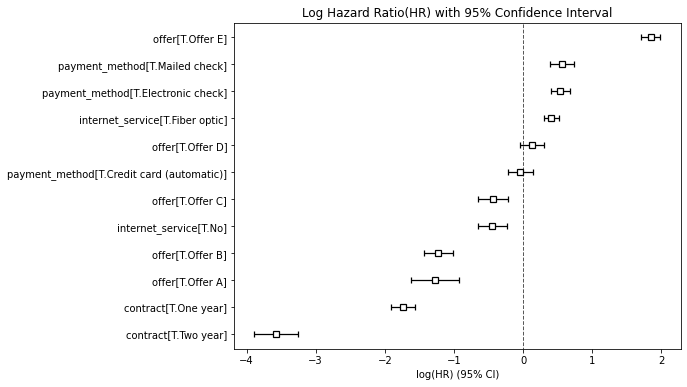

In [15]:
#plot with coef ci for visual
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])
plt.title('Log Hazard Ratio(HR) with 95% Confidence Interval')
plt.show()

*Interpretation: Based on the values of coef upper and lower bounds with 95% confidence interval of the covariates. As the interpretation above, the likelihood of churn and vice versa are inferred from the exp(coef)*

## 5.3 Model Prediction Validation

In this section, we will predict and compare the estimation of our random forest model prediction results on the customer churn tendency to draw inferences and verify the model's prediction capacity. 

### 5.3.1 Survival Analysis Prediction Probability to Churn

Survival Analysis and the Lifeline Libraries are able to provide probability predictions on the customer survival tenure.

In [16]:
#filter censored customers 
censored_data = telco[telco['customer_status'] == 0]

# create the tenure column for each customer
censored_data_last_obs = censored_data['tenure_months']

# Predict the survival function for each customer from this day onwards
conditioned_sf = cph.predict_survival_function(censored_data, conditional_after = censored_data_last_obs)

# Predict the month where the survival probability falls below the median
predictions_50 = median_survival_times(conditioned_sf)

#drop customer that doesnt churn 
surv_preds = predictions_50.T.replace(np.inf, np.nan).dropna()
surv_preds.head()

,0.5
477,9.0
478,12.0
479,26.0
480,40.0
484,16.0


In this prediction, we have selected the customers in which is still active, with a prediction of survival probability lower than 50%. In this context, the customer of index 477 has a survival probability another 9 months. 

### 5.3.2 Comparison Survival Analysis Prediction and Random Forest Model Prediction

From the last notebook, we have extracted the false positve and false negative predictions. In this section, we will make quick comparison to evaluate our model false positive prediction to the survival analysis prediction.

In [17]:
#extract index from the predicted 
surv_preds_index = surv_preds.index

In [18]:
surv_preds

,0.5
477,9.0
478,12.0
479,26.0
480,40.0
484,16.0
...,...
7034,11.0
7035,23.0
7036,35.0
7037,60.0


In [19]:
#provide counts to compare the false positive counts made
falsepo_count = []
falseneg_count = []

for i in pd.Series(surv_preds_index):
    for j in false_po['Unnamed: 0']:
        if i == j:
            falsepo_count.append(i)
    for j in false_neg['Unnamed: 0']:
        if i == j:
            falseneg_count.append(i)
            
print(f'False Positive Prediction: {len(falsepo_count)}') #1134 out of  1201
print(f'False Negative Prediction: {len(falseneg_count)}') #0 out of 233

False Positive Prediction: 1134
False Negative Prediction: 0


We can conclude that the hypothesis where the models predicts on false positives are indication of high churn likelihood customers. In this note, we will extract the predictions on the survival analysis on the churn months, we can implement this information along with its call to action for dashboard implementation.

## 5.4 Merge Predictions for Dashboard Deployment

In [20]:
#to merge with surv pred for dashboard
dash_df = pd.merge(telco, predictions_50.T, left_index=True, right_index=True, how='outer')

In [21]:
#drop unused cols
dash_df = dash_df.rename(columns={0.5:'months_to_churn'}).drop(columns=['pop_density','new_user','under_30','senior_citizen','dependents','number_of_dependents'])

In [22]:
def rename_str(df,target_col):
    rename_col = []
    for i in range(len(dash_df)):
        rename = df.loc[i][target_col].replace('_',' ').title()
        rename_col.append(rename)
    return rename_col

In [23]:
#rename cluster
dash_df['cluster'] = rename_str(dash_df,'cluster')

#convert values
dash_df.months_to_churn = dash_df.months_to_churn.replace({np.inf : 80, np.nan : 0})
dash_df['gender'] = dash_df['gender'].replace({0:'Male', 1:'Female'})

#export for dashboard
dash_df.to_csv('../data/telco_clustered_dash.csv', index=False)

## 5.5 Conclusion and Recommendations

Looking back at Random Forest Model predictions, we have successfully model and predict the customer churn of the telco dataset with 69% F1 Harmonic Score. With 5174 currently still active customer, we are able to identify 1201 customers with tendency to churn. These information are look ahead for the business and translated for a call to action via the customer quadrant.

Survival Analysis that was conducted with under the following caveat on the assumptions. As our goal in this project is survival prediction, we will not take into account on the proportional hazards assumption violations. More can be found in the lifelines documentation [(Lifelines, 2021)](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html).

Married users are 1.51 times more likely to churn, whereas contract users of two years are 0.43 times more likely to stay. In summary, internet_service using fiber optic, payment method using electronic check, offer E, and streaming tv services are features that the business needs to look into. The driving factors that affects the customer churn are month-to-month basis contract customers, payment via electronic checks, fibre optic and streaming services connectivity which requires more investigation on the logistics and hardware of the actual services.

The following shall be taken account for as well as we build retention strategy:

**Questions to ask:**

1. Does *Offer E* has an combination of promotion that has high turnover rate? If yes, what can be done to improve the promotional value of Offer E, else shall Offer E be terminated entirely and be replaced.

2. Does *internet service users of fiber optic* has difficulty in connectivity? Is the logistic support for performance of the fiber optic well optimized for the majority of the user base. Is the technical support team well equipt with the knowledge to assist users in need?

3. Does the payment using *electronic check* issue inconvenience to users during payment? If other payment method is viable, is the a lack of information of other payment methods made known to users?

4. Does *streaming tv* encounter data speed limitation? If there is connectivity issues, are these due to lack of infrastucture to support the signal transmissons?

Alternatively, the long term contracts offers, online security, tech support, online back up has prove to be a value-added service to the users as the subscription to it led to user more likely to stay with the business. 

This model has been limited for further investigation and exploration due to its lack of time-series features in the original dataset, which is considered a key feature in customer-driven analysis. Hence with modification, the model can be retrained for other business use case especially on the clustering of customer base. 